In [1]:
import sys
sys.path.append('../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from codes.docs.analysis import data_preprocessing,genetic_file_preprocess
from codes.docs.analysis.nimagen import stats, visualisation, genes
import time

# Volumetric analysis

In [2]:
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

In [3]:
european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

In [37]:
prs_imputed = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_euro_batch2_imputed.gwas.all.score',
                                                                            column_prefix='ASD_PRS_imputed_Pt_')
prscs_imputed = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../codes/gene_set/PRScs/asd/ASD_imputed.profile',column_prefix='ASD_PRScs_imputed_')
prscs = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../codes/gene_set/PRScs/asd/plink.profile',column_prefix='ASD_PRScs_')
european_volumetric_dataset_term = european_volumetric_dataset_term.merge(prs_imputed,on='ID').merge(prscs[['ID','ASD_PRScs_SCORESUM']],on='ID').merge(prscs_imputed[['ID','ASD_PRScs_imputed_SCORESUM']],on='ID')

In [4]:
df = european_volumetric_dataset_term.copy()
print(df.shape)
ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers
df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)
print(df.shape)
df = df.drop(columns=['ASD_PRS_Pt_1e-07'])

(279, 191)
(273, 191)


In [6]:
pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS_Pt' in i],
    scaling=True,
    n_components=1
)
df['PRS_pca'] = prs_pca
pca, prs_pca_imputed, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS_imputed_Pt' in i],
    scaling=True,
    n_components=1
)
df['PRS_pca_imputed'] = prs_pca_imputed

In [ ]:
df['ID/Ses'] = 'sub-'+df['ID']+'/ses-'+df['Session'].astype('str')

In [7]:
df = pd.read_csv('df_euro_asd.csv')

In [44]:
# to_copy = df[['ID/Ses','sex','GA','PMA','TBV','PRS_pca','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3']].copy()
# to_copy.to_csv('../../codes/DrawEMVol/Jacobians_volume_ASDPCA_after_ancestry_outliers.txt',header=None,index=False)
# with open('../../codes/DrawEMVol/Jacobians_volume_ASDPCA_after_ancestry_outliers.txt','w') as file:
#     file.write(' '.join(["#"] + to_copy.columns.tolist()) + '\n')
#     to_copy.to_csv(file,header=None,index=None)

In [45]:
new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['lobe','hemisphere','gmwm2gether'],drop_duplicates=True)

In [46]:
# new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['lobe','hemisphere','gmwm2gether'])

new_df['Frontal lobe TTV'] = new_df['Imperial 36']
new_df['Parietal lobe TTV'] = new_df['Imperial 38']
new_df['Occipital lobe TTV'] = new_df['Imperial 15']
new_df['Temporal lobe TTV'] = new_df['Imperial 5']
new_df['Frontal+Temporal TTV'] = new_df['Frontal lobe TTV'] + new_df['Temporal lobe TTV']
new_df['Parietal+Occipital TTV'] = new_df['Parietal lobe TTV'] + new_df['Occipital lobe TTV']

In [47]:
euro_result = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(new_df,
                                                                                        thresholds=['PRS_pca'],
                                                                                        cat_independentVar_cols=['sex'],
                                           cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
                                           dependentVar_cols=[i for i in new_df.columns if 'TTV' in i])


100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


In [85]:
df_cortical_regions = data_preprocessing.Volumes.Imperial.get_segment(df,lobe=['frontal','temporal','occipital','parietal'])

In [119]:
_, euro_result_individual_cortical_region = stats.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['PRS_pca','GA','PMA','TBV']+ancestry,
    dependentVar_cols=df_cortical_regions,
    )

In [120]:
to_plot_values = euro_result_individual_cortical_region[["standardize(Q('PRS_pca'))_coef"]].copy()
plot_labels = [int(i.replace('Imperial ','')) for i in to_plot_values.index]
prs_plot_value_values = to_plot_values.values.reshape(-1).tolist()
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 

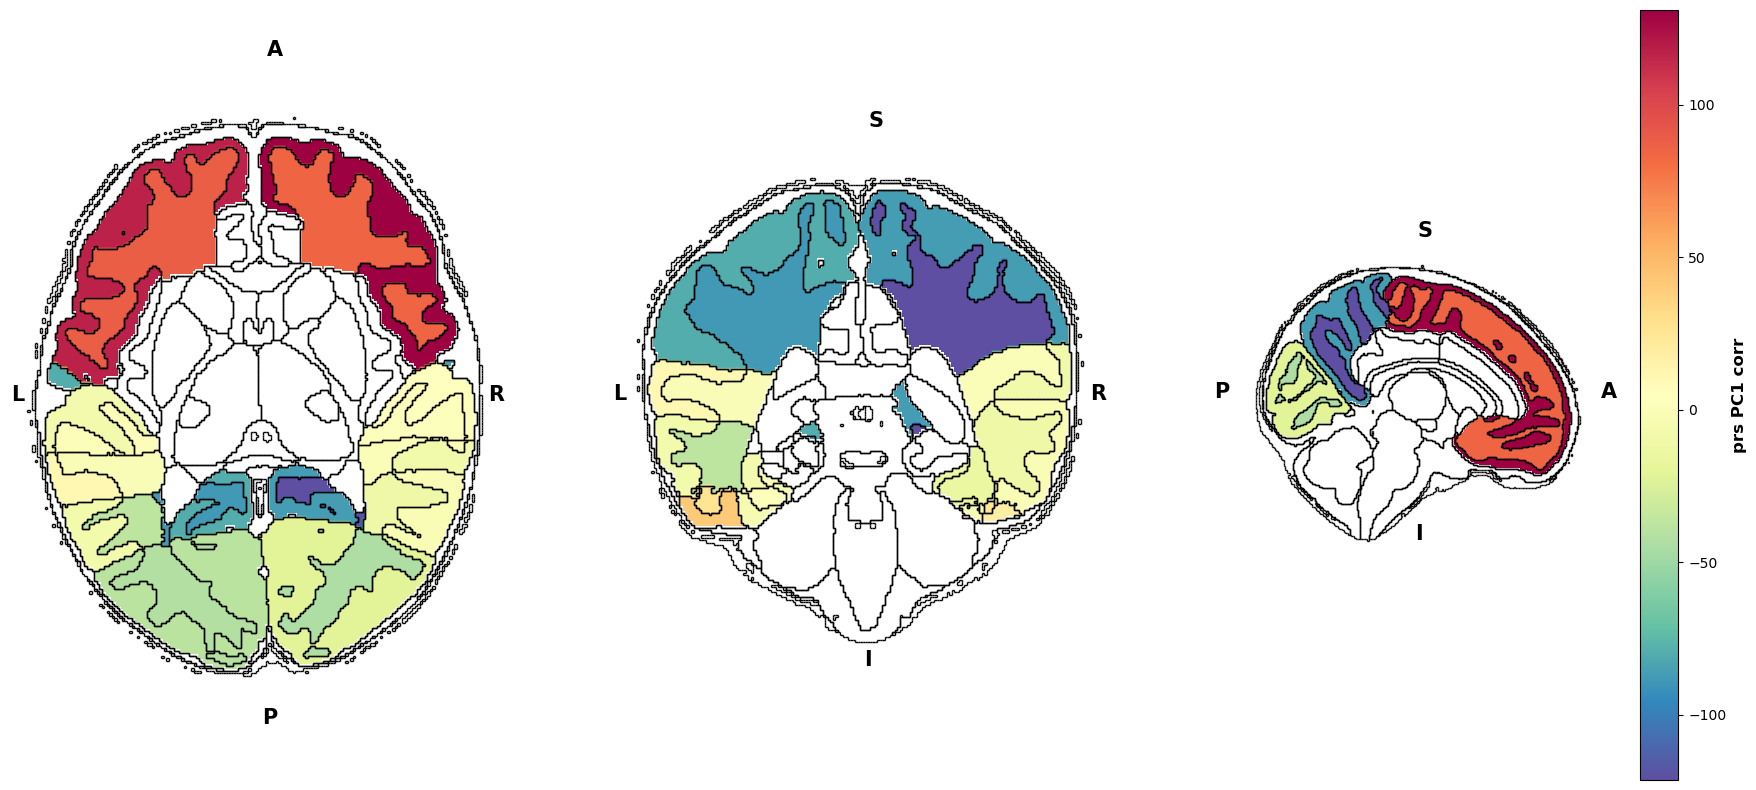

In [121]:
_,_ = visualisation.Brainmap.plot_segmentation(
    # atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    cb_title='prs PC1 corr')

In [122]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/Imperial/atlas_t40.nii.gz')

In [123]:
standardized_ROIs_coord = ROIs_coord.copy()
standardized_ROIs_coord[['X','Y','Z']] = stats.StandardScaler().fit_transform(ROIs_coord[['X_vox','Y_vox','Z_vox']])
standardized_ROIs_coord = standardized_ROIs_coord.set_index('Label')

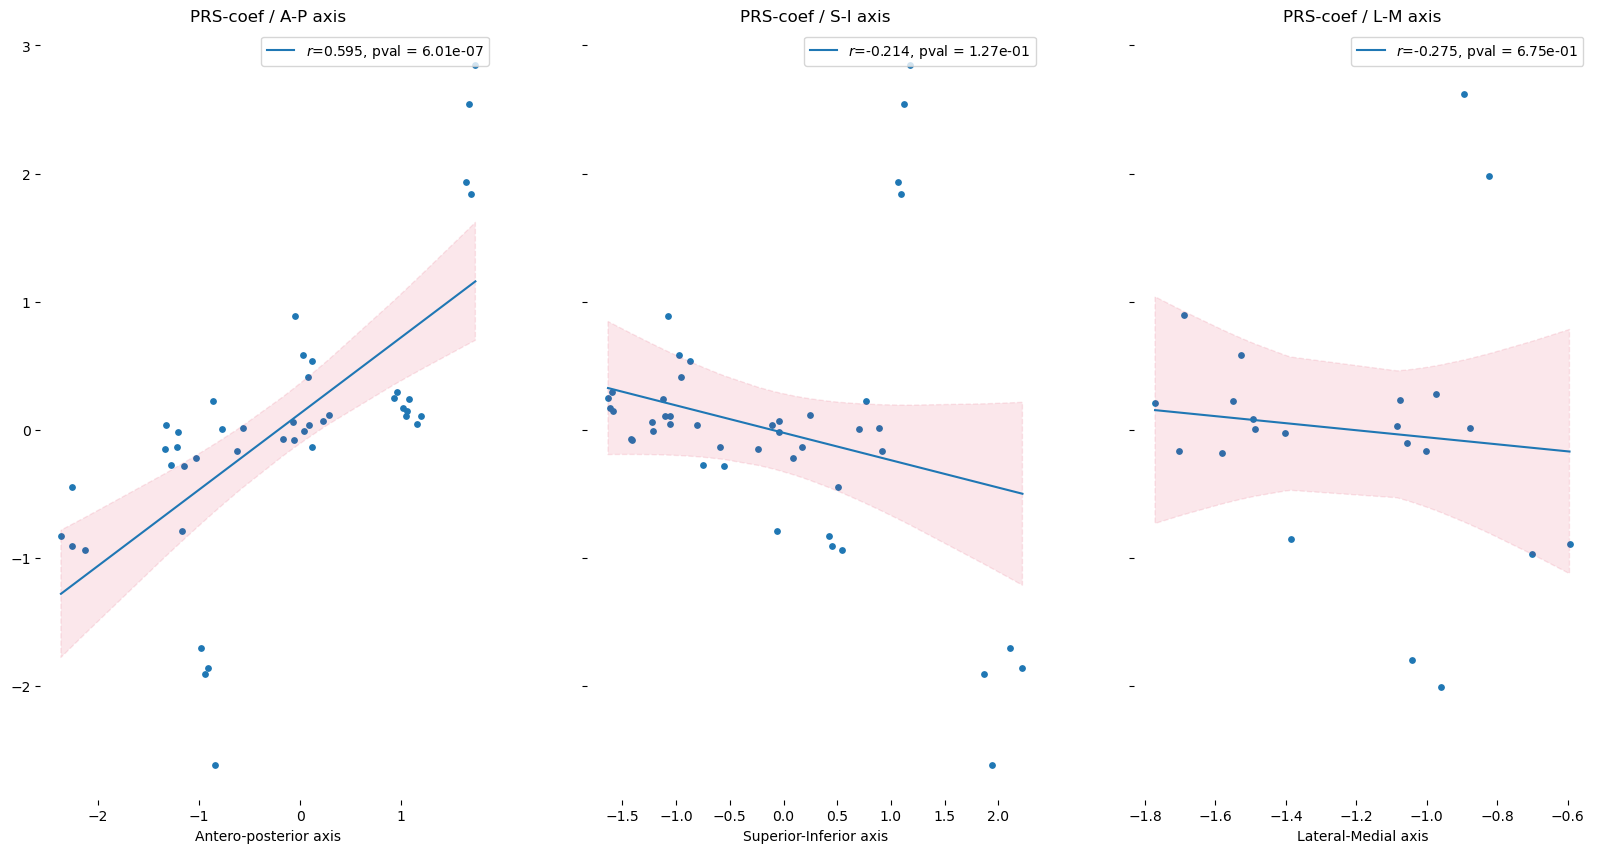

In [124]:
standardized_ROIs_coord = ROIs_coord.copy()
standardized_ROIs_coord[['X','Y','Z']] = stats.StandardScaler().fit_transform(ROIs_coord[['X_vox','Y_vox','Z_vox']])
standardized_ROIs_coord = standardized_ROIs_coord.set_index('Label')
fig,axes = plt.subplots(1,3,figsize=(20,10),sharey=True)
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[prs_plot_values.keys(),'Y'],
                                  y=prs_plot_value_values, 
                                  # annotate=[Imperial_labels[i]['abbr'] for i in loading_matrix.index], 
                                  xlabel='Antero-posterior axis',scaling='y',return_stats=True,legend=True,title='PRS-coef / A-P axis',ax=axes[0],
                                 legend_loc='upper right',markersize=15)
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[prs_plot_values.keys(),'Z'],
                                  y=prs_plot_value_values,
#                                   annotate=[Imperial_labels[i]['abbr'] for i in loading_matrix.index],
                                  xlabel='Superior-Inferior axis',scaling='y',return_stats=True, legend=True,title='PRS-coef / S-I axis',ax=axes[1],
                                 legend_loc='upper right',markersize=15)
left_right_values_to_plot = data_preprocessing.Volumes.Imperial.get_segment({f'Imperial {k}':v for k,v in prs_plot_values.items()},side='left')
left_right_values_to_plot = {int(k.replace('Imperial ','')):v for k,v in left_right_values_to_plot.items()}
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[left_right_values_to_plot.keys(),'X'],
                                  y=[i for i in left_right_values_to_plot.values()], 
#                                   annotate=[Imperial_labels[i]['abbr'] for i in data_preprocessing.Volumes.Imperial.get_segment(pd.DataFrame(loading_matrix[pc]),col='index',side=['left']).index],
                                  # ylabel='PC8~BrainVol corr', 
                                  xlabel='Lateral-Medial axis',scaling='y',return_stats=True, legend=True,title='PRS-coef / L-M axis',ax=axes[2],
                                 legend_loc='upper right',markersize=15)
sns.despine(bottom=True,right=True,left=True,top=True)

In [380]:
_, euro_AAL = stats.MassUnivariate.mass_univariate(
    new_df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['PRS_pca','GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in new_df.columns if 'AAL' in i]
    )

In [381]:
euro_AAL.sort_values(by="standardize(Q('PRS_pca'))_pval")

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
AAL_20,3320.294395,1.671862e-246,4.262535,0.905949,48.594294,0.003054,34.551491,0.097374,-261.280660,1.949380e-15,445.644225,9.776377e-43,15.709784,0.341251,-12.808567,0.434491,0.263426,0.987202
AAL_28,944.452492,8.264381e-224,-11.635038,0.354331,16.046894,0.004893,13.475028,0.063308,-96.692708,4.861512e-17,143.365762,2.553505e-38,13.697640,0.017578,-8.363423,0.143022,4.963527,0.385341
AAL_69,1239.075694,2.210573e-183,-3.285997,0.889674,30.240491,0.004955,13.890468,0.309322,-134.900404,1.710762e-10,187.087257,4.518928e-22,3.480602,0.747925,-4.166815,0.698473,12.486800,0.247462
AAL_70,747.414645,5.153143e-188,1.579835,0.908192,17.046559,0.006147,6.890223,0.383093,-64.466621,9.328764e-08,90.289935,1.415924e-16,1.952592,0.755236,-8.730157,0.161218,0.418947,0.946438
AAL_27,1227.976936,4.266673e-239,-9.772882,0.492934,17.673196,0.006304,6.930315,0.398888,-116.260310,1.124390e-18,196.151060,1.974389e-49,6.242515,0.338261,-0.510745,0.937065,-1.206513,0.852422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAL_84,1274.862838,5.321142e-230,-29.852178,0.063503,0.485767,0.946435,8.786784,0.342020,-95.412097,2.942372e-11,147.067823,8.791028e-28,9.561916,0.192807,5.385890,0.459643,-1.639058,0.822334
AAL_54,1366.716643,1.604488e-197,4.022188,0.861100,0.616100,0.952602,5.674132,0.668427,-120.084290,3.815922e-09,241.307595,5.977456e-34,-5.291944,0.614639,0.046875,0.996416,-8.017435,0.443804
AAL_67,8038.555345,6.045895e-276,10.155467,0.880184,0.858269,0.977461,64.873761,0.095574,-664.384340,4.103591e-25,1117.250237,1.936181e-62,28.469930,0.355686,11.282425,0.712272,25.256804,0.410494
AAL_82,5736.040543,1.329117e-258,-89.528169,0.110792,-0.704217,0.977755,-16.889430,0.600840,-424.766066,1.279979e-16,702.921156,1.125308e-43,6.223718,0.807961,-33.564641,0.187575,-7.148443,0.779200


In [382]:
to_plot_values = euro_AAL[["standardize(Q('PRS_pca'))_coef"]].copy()

In [383]:
plot_labels = [int(i.replace('AAL_','')) for i in to_plot_values.index]
prs_plot_value_values = to_plot_values.values.reshape(-1).tolist()
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 

(<Figure size 2200x1000 with 4 Axes>,
 defaultdict(dict,
             {'sagittal': {'ax': <Axes: >,
               'atlas': array([[nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      ...,
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan]]),
               'original_atlas': array([[nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      ...,
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan]]),
               'im': <matplotlib.image.AxesImage at 0x7fc866a37d90>},
              'axial': {'ax': <Axes: 

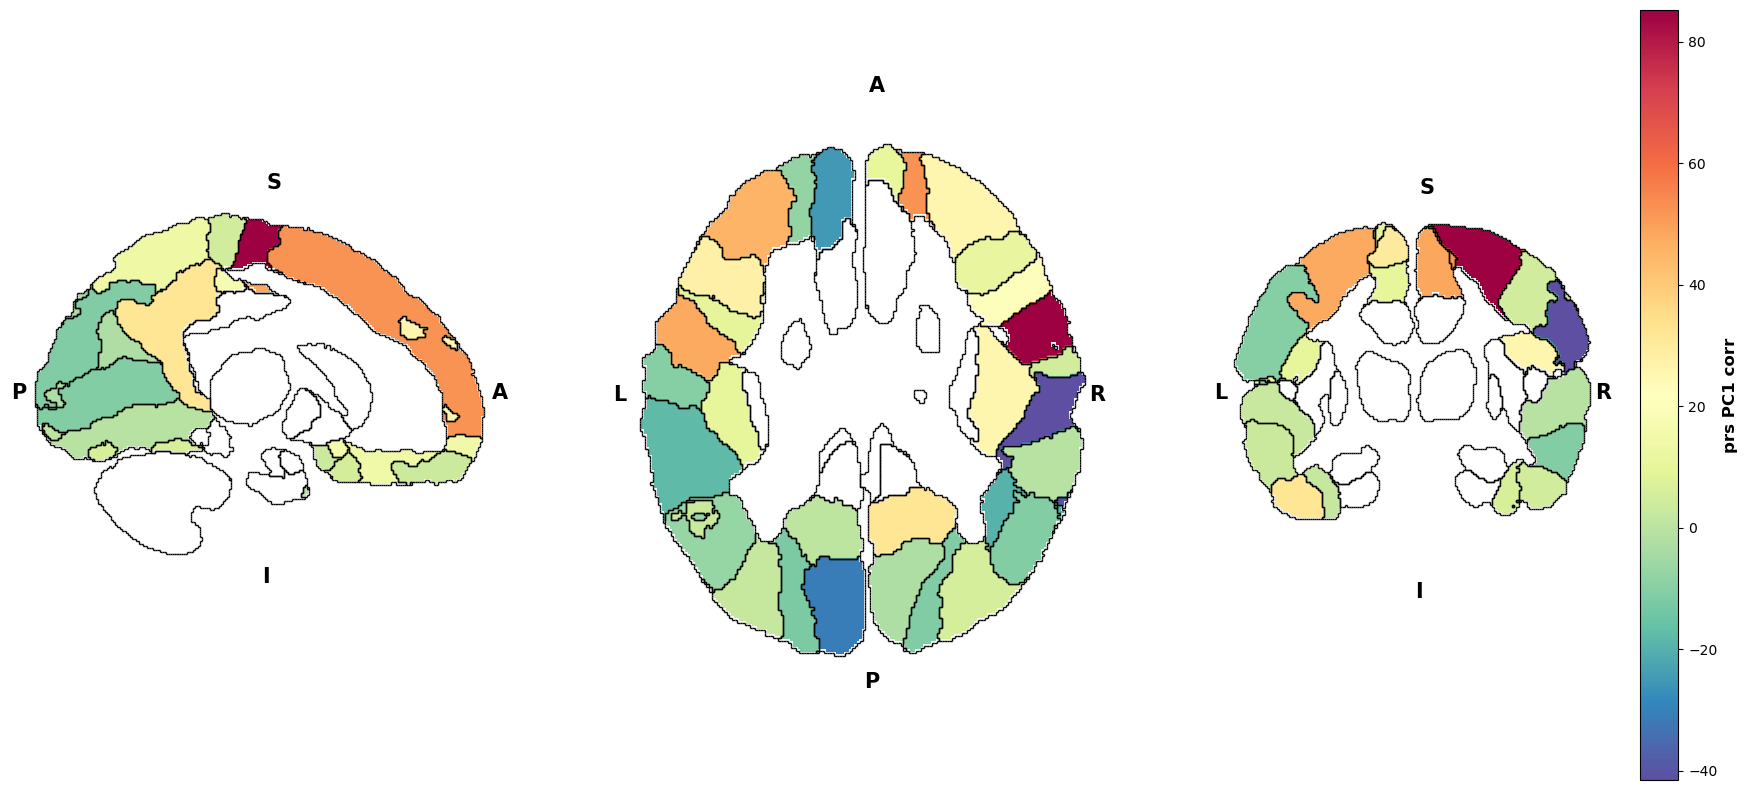

In [386]:
visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    cb_title='prs PC1 corr')

# Jacobians analysis

In [8]:
df = pd.read_csv('df_euro_asd.csv')
ancestry = [f'euro_Anc_PC{i}' for i in range(1,4)]

In [9]:
mean_jacobians = pd.read_csv('../../codes/DrawEMVol/mean_Jacobians/mean_jacobians_drawEM.txt',sep=' ',header=None)
mean_jacobians.columns = ['ID/Ses']+[f'Imperial {i}' for i in mean_jacobians.columns.tolist()[1:]]
mean_jacobians['ID'] =  mean_jacobians['ID/Ses'].apply(lambda x: x.split('_')[0].replace('sub-',''))
mean_jacobians['Session'] =  mean_jacobians['ID/Ses'].apply(lambda x: x.split('_')[1].replace('ses-','')).astype('int')

In [10]:
mean_jacobians = mean_jacobians.merge(df[['ID','GA','PMA','sex','TBV','ICV']+ancestry+[i for i in df.columns if 'PRS' in i]],on='ID')

In [17]:
mean_jacobians_cortical_regions = data_preprocessing.Volumes.Imperial.get_segment(mean_jacobians,lobe=['frontal','temporal','occipital','parietal'])

In [68]:
# mean_jacobians_cortical_regions = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(mean_jacobians_cortical_regions,grouping=['gmwm2gether'],drop_duplicates=True)

In [18]:
mean_jacobians_results = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    mean_jacobians,
    thresholds=['PRS_pca'],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA']+ancestry,
    dependentVar_cols=[i for i in mean_jacobians_cortical_regions.columns if 'Imperial ' in i]
)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


In [70]:
stats.MultipleCorrection.matSpDLite(mean_jacobians_cortical_regions.corr())

Effective Number of Independent Variables [Veff] is 41.95589416354933
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 27.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0018518518518518521


26.999999999999996

In [13]:
len(mean_jacobians_results.sort_values(by='PRS_pval'))

44

In [19]:
to_plot_values_jacobians = mean_jacobians_results[["PRS_coef"]].copy()
plot_labels_jacobians = [int(i.replace('Imperial ','')) for i in mean_jacobians_results['Connection']]
prs_plot_value_values_jacobians = to_plot_values_jacobians.values.reshape(-1).tolist()
prs_plot_values_jacobians = dict(zip(plot_labels_jacobians,prs_plot_value_values_jacobians)) 

172.29723501205444


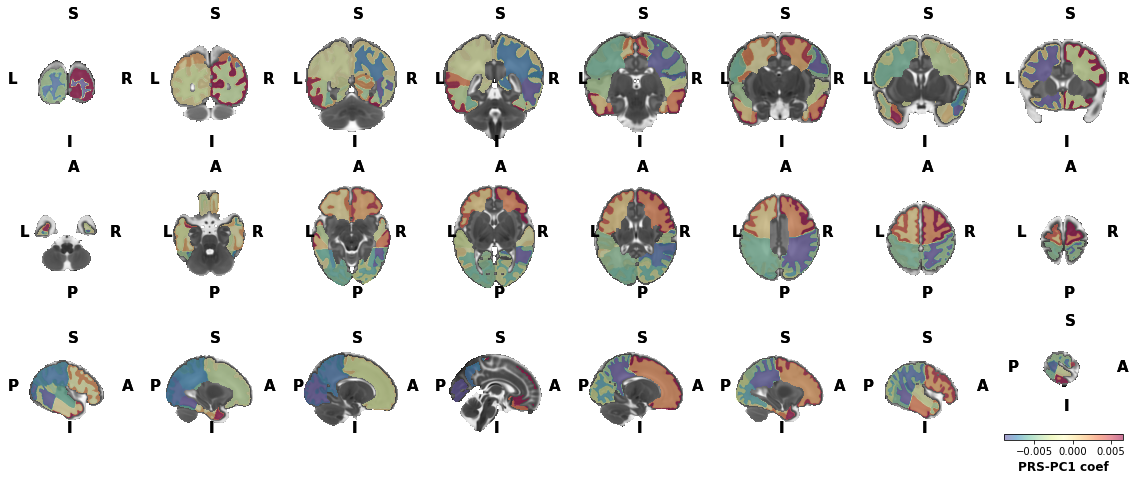

In [88]:
T2_file = '../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-mean-T2.nii.gz'
drawem_parcellation = '../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz'
fig,axes = plt.subplots(3,8,figsize=(20,8))
begin = time.time()
for ax,atlas_slice in zip(axes[0,:],np.linspace(40,180,8)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['coronal'],
        atlas_file=T2_file,T2=True,cmap='gray',axes=[ax],background_value=1)
    _,_ = visualisation.Brainmap.plot_segmentation(
            atlas_file=drawem_parcellation,
            plot_values=prs_plot_values_jacobians,
            outline_alpha=0,
            map_view=['coronal'],
            atlas_slice = int(atlas_slice),axes=[ax],image_alpha=.55,cmap_reversed=True,colorbar=False,fig=fig)

for ax,atlas_slice in zip(axes[1,:],np.linspace(40,180,8)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['axial'],
        atlas_file=T2_file,T2=True,cmap='gray',axes=[ax],background_value=1)
    _,_ = visualisation.Brainmap.plot_segmentation(
            atlas_file=drawem_parcellation,
            plot_values=prs_plot_values_jacobians,
            outline_alpha=0,
            map_view=['axial'],
            atlas_slice = int(atlas_slice),axes=[ax],image_alpha=.55,cmap_reversed=True,colorbar=False,fig=fig)

for ax,atlas_slice in zip(axes[2,:],np.linspace(40,180,8)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['sagittal'],
        atlas_file=T2_file,T2=True,cmap='gray',axes=[ax],background_value=1)
    if atlas_slice == 180:
        _,_ = visualisation.Brainmap.plot_segmentation(
            atlas_file=drawem_parcellation,
            outline_alpha=0,
            plot_values=prs_plot_values_jacobians,
            map_view=['sagittal'],
            atlas_slice = int(atlas_slice),axes=[ax],image_alpha=.55,cmap_reversed=True,colorbar=True,fig=fig,
            cb_title='PRS-PC1 coef',cb_orientation='horizontal')
    else:
        _,_ = visualisation.Brainmap.plot_segmentation(
            atlas_file=drawem_parcellation,
            outline_alpha=0,
            plot_values=prs_plot_values_jacobians,
            map_view=['sagittal'],
            atlas_slice = int(atlas_slice),axes=[ax],image_alpha=.55,cmap_reversed=True,colorbar=False,fig=fig)
fig.savefig('mean_regional_jacobians.png')
print(time.time()-begin)

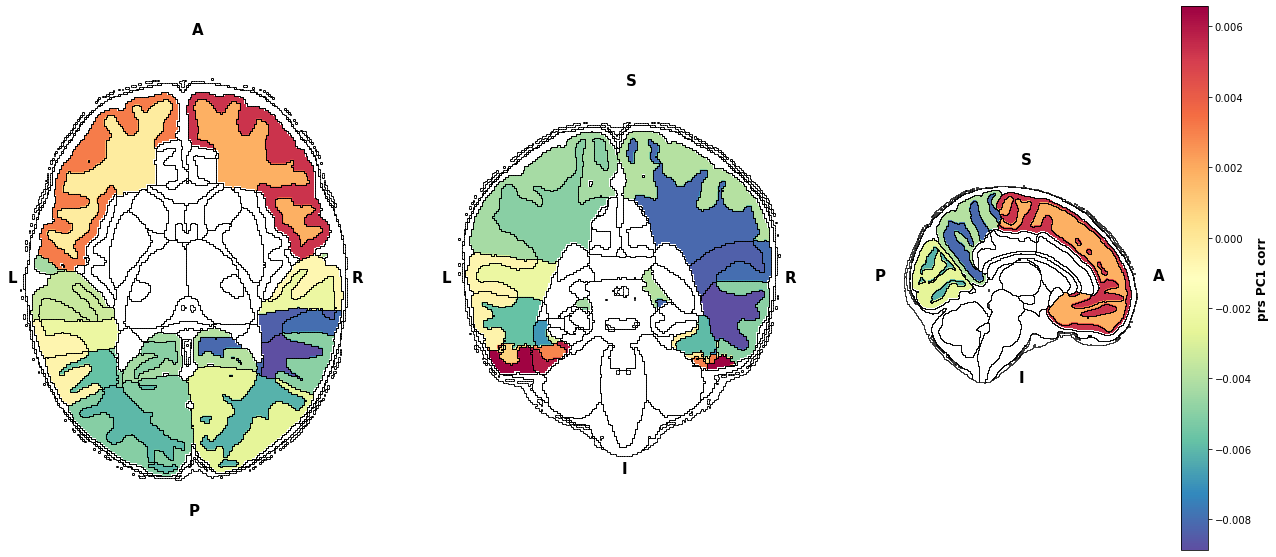

In [19]:
_,_ = visualisation.Brainmap.plot_segmentation(
    # atlas_slice=120,
    plot_values=prs_plot_values_jacobians,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    cb_title='prs PC1 corr')

In [16]:
mean_jacobians_cortical_regions

,Imperial 11,Imperial 12,Imperial 13,Imperial 14,Imperial 15,Imperial 16,Imperial 22,Imperial 23,Imperial 26,Imperial 27,...,Imperial 70,Imperial 71,Imperial 72,Imperial 73,Imperial 74,Imperial 79,Imperial 8,Imperial 80,Imperial 81,Imperial 82
0,-0.082317,0.001033,0.001032,-0.062554,-0.050221,-0.153159,-0.003575,-0.077399,0.130134,0.126712,...,0.027164,0.014811,-0.098430,-0.179641,-0.144569,-0.048782,-0.034640,-0.034143,-0.080992,-0.055807
1,-0.145327,-0.099443,-0.051029,-0.023046,-0.042391,0.008593,-0.072487,-0.021539,0.049008,0.099860,...,0.022551,-0.093826,-0.037651,-0.057529,-0.155917,-0.046876,-0.155025,-0.036254,-0.023399,-0.023137
2,0.034846,0.035260,-0.053174,-0.085331,0.093215,0.047978,-0.083316,-0.087316,0.085316,0.160815,...,0.163792,0.049606,-0.063494,0.197863,0.015008,-0.028904,-0.091948,-0.024836,0.042965,0.006026
3,-0.019219,-0.067055,0.012158,-0.037427,0.033584,-0.037167,-0.000122,-0.042575,0.018372,0.016963,...,-0.053140,0.056039,-0.109329,-0.075104,-0.059771,-0.021825,-0.029896,-0.036392,0.011016,-0.013212
4,-0.012209,-0.095494,-0.046581,-0.029473,0.017601,-0.060286,0.036075,0.049192,0.034727,-0.068311,...,-0.203151,-0.032479,-0.041519,-0.064513,-0.159552,-0.094188,-0.091030,-0.094143,-0.073931,-0.094956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,-0.039269,-0.058782,-0.106157,-0.138999,0.082131,0.057591,-0.068462,0.007077,0.107851,0.057420,...,-0.070597,-0.020688,0.027566,-0.100052,-0.257657,-0.025927,0.035598,-0.027212,-0.088010,-0.089899
269,-0.013898,-0.065473,-0.097480,-0.196732,-0.185498,-0.099079,0.000119,0.050012,-0.037287,-0.116851,...,-0.118170,-0.013937,-0.029665,-0.004893,0.002281,-0.065697,-0.212227,-0.042164,-0.031022,-0.058199
270,-0.116069,-0.140780,-0.024684,-0.077300,0.079539,0.118729,-0.127744,-0.145256,0.071786,0.025545,...,-0.005493,0.000431,0.000648,-0.112923,-0.103677,-0.010332,-0.220982,0.024497,-0.043697,-0.015082
271,-0.087977,-0.029826,-0.064899,-0.005591,0.064520,-0.060496,-0.167516,-0.015314,-0.247263,0.053160,...,0.017572,-0.006899,-0.070303,-0.172446,-0.054946,-0.041662,-0.078988,-0.019530,-0.065835,-0.064168


In [20]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/Imperial/atlas_t40.nii.gz')

In [133]:
# mean_jacobians_cortical_regions_adjusted = stats.MassUnivariate.adjust_covariates_with_lin_reg(
#     mean_jacobians_cortical_regions,
#     cat_independentVar_cols=df['sex'],
#     cont_independentVar_cols=df[['PRS_pca']],
#     dependentVar_cols=[i for i in mean_jacobians_cortical_regions.columns if 'Imperial' in i]
# )

In [36]:
np.corrcoef(ROIs_coord.loc[prs_plot_values_jacobians.keys(),'Y_sca'],
           prs_plot_value_values_jacobians)

array([[1.        , 0.52168049],
       [0.52168049, 1.        ]])

In [41]:
full_legend = {k:v['abbr'] for k,v in data_preprocessing.Volumes.Imperial.get_Imperial_legends().items()}

In [70]:
prs_plot_values_jacobians_df = pd.DataFrame(prs_plot_values_jacobians,index=[0]).T
prs_plot_values_jacobians_df = prs_plot_values_jacobians_df.reset_index()
prs_plot_values_jacobians_df.columns = ['Label','PRS_coef']

In [74]:
plot_coordinates = prs_plot_values_jacobians_df.merge(ROIs_coord,on='Label')

In [76]:
plot_coordinates['abbr'] = plot_coordinates['Label'].apply(lambda x: full_legend[f'Imperial {x}'])

In [85]:
plot_coordinates.sort_values(by='Label')

,Label,PRS_coef,X_vox,Y_vox,Z_vox,X_sca,Y_sca,Z_sca,abbr
18,5,0.008636,60.979500,160.592403,51.821978,-18.041500,-4.235056,-13.096827,ATL.GM.left.medial
26,6,0.004545,140.444429,163.718101,52.267737,21.690965,-2.672207,-12.873948,ATL.GM.right.medial
33,7,0.005413,37.725238,164.617571,64.003216,-29.668631,-2.222472,-7.006208,ATL.GM.left.lateral
40,8,0.003061,162.709004,168.447320,65.747029,32.823252,-0.307598,-6.134302,ATL.GM.right.lateral
0,11,-0.003447,31.523008,133.604356,97.191093,-32.769746,-17.729079,9.587730,STG.GM.left.middle
1,12,-0.000750,168.733760,139.030384,98.967407,35.835630,-15.016066,10.475887,STG.GM.right.middle
2,13,0.006446,32.066456,128.415956,65.294901,-32.498022,-20.323280,-6.360366,MAITG.GM.left.anterior
3,14,0.006566,169.198490,132.586999,68.232486,36.067995,-18.237758,-4.891573,MAITG.GM.right.anterior
4,15,0.005893,57.676516,124.436685,56.409056,-19.692992,-22.312915,-10.803288,LOG.GM.left.anterior
5,16,0.002908,144.673043,128.176082,56.706471,23.805271,-20.443217,-10.654581,LOG.GM.right.anterior


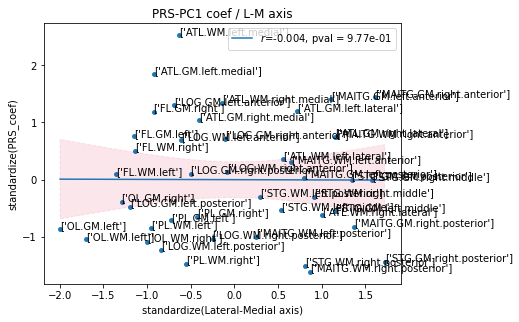

In [117]:
visualisation.SimplePlots.Scatter(x=abs(plot_coordinates['X_sca']),
                                  y='PRS_coef', 
                                  data=plot_coordinates,
                                  annotate='abbr',
                                  xlabel='Lateral-Medial axis',scaling='both',return_stats=True, legend=True,title='PRS-PC1 coef / L-M axis',
                                 legend_loc='upper right',markersize=15)


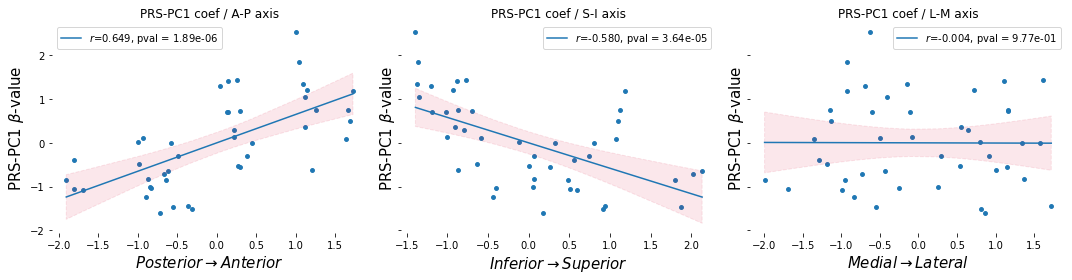

In [150]:

fig,axes = plt.subplots(1,3,figsize=(15,4),sharey=True)
visualisation.SimplePlots.Scatter(x='Y_sca',
                                  y='PRS_coef', 
                                  data=plot_coordinates,
                                  xlabel='Antero-posterior axis',scaling='both',return_stats=True,legend=True,title='PRS-PC1 coef / A-P axis',ax=axes[0],
                                 legend_loc='upper left',markersize=15)
visualisation.SimplePlots.Scatter(x='Z_sca',
                                  y='PRS_coef',
                                  data=plot_coordinates,
                                  xlabel='Superior-Inferior axis',scaling='both',return_stats=True, legend=True,title='PRS-PC1 coef / S-I axis',ax=axes[1],
                                 legend_loc='upper right',markersize=15)
visualisation.SimplePlots.Scatter(x=abs(plot_coordinates['X_sca']),
                                  y='PRS_coef', 
                                  xlabel='Lateral-Medial axis',scaling='both',return_stats=True, legend=True,title='PRS-PC1 coef / L-M axis',ax=axes[2],
                                  data=plot_coordinates,
                                 legend_loc='upper right',markersize=15)
axes[0].set_ylabel(r'PRS-PC1 $\beta$-value',fontsize=15)
axes[1].set_ylabel(r'PRS-PC1 $\beta$-value',fontsize=15)
axes[2].set_ylabel(r'PRS-PC1 $\beta$-value',fontsize=15)
axes[0].set_xlabel(r'$\it{Posterior}\rightarrow\it{Anterior}$',fontsize=15)
axes[1].set_xlabel(r'$\it{Inferior}\rightarrow\it{Superior}$',fontsize=15)
axes[2].set_xlabel(r'$\it{Medial}\rightarrow\it{Lateral}$',fontsize=15)
# fig.text(0.05,0,'$\it{Posterior}$')

# fig.text(0.28,0,r'$\it{Anterior} \rightarrow$')
sns.despine(bottom=True,right=True,left=True,top=True)
plt.tight_layout()
fig.savefig('ROI_coordinates_Jacobians.png')

In [168]:
print(plot_coordinates[['abbr','PRS_coef','X_vox','Y_vox','Z_vox','X_sca','Y_sca','Z_sca']].to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
                    abbr &  PRS\_coef &      X\_vox &      Y\_vox &      Z\_vox &      X\_sca &      Y\_sca &      Z\_sca \\
\midrule
      STG.GM.left.middle & -0.003447 &  31.523008 & 133.604356 &  97.191093 & -32.769746 & -17.729079 &   9.587730 \\
     STG.GM.right.middle & -0.000750 & 168.733760 & 139.030384 &  98.967407 &  35.835630 & -15.016066 &  10.475887 \\
  MAITG.GM.left.anterior &  0.006446 &  32.066456 & 128.415956 &  65.294901 & -32.498022 & -20.323280 &  -6.360366 \\
 MAITG.GM.right.anterior &  0.006566 & 169.198490 & 132.586999 &  68.232486 &  36.067995 & -18.237758 &  -4.891573 \\
    LOG.GM.left.anterior &  0.005893 &  57.676516 & 124.436685 &  56.409056 & -19.692992 & -22.312915 & -10.803288 \\
   LOG.GM.right.anterior &  0.002908 & 144.673043 & 128.176082 &  56.706471 &  23.805271 & -20.443217 & -10.654581 \\
             OL.GM.right & -0.002638 & 127.874835 &  57.564563 & 105.623475 &  15.406167 & -55.748976 &  13.803921 \\
     

/var/folders/2_/td23gmrj5b5g490r04bm1q7h0000gn/T/ipykernel_1327/1654877272.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(plot_coordinates[['abbr','PRS_coef','X_vox','Y_vox','Z_vox','X_sca','Y_sca','Z_sca']].to_latex(index=False))


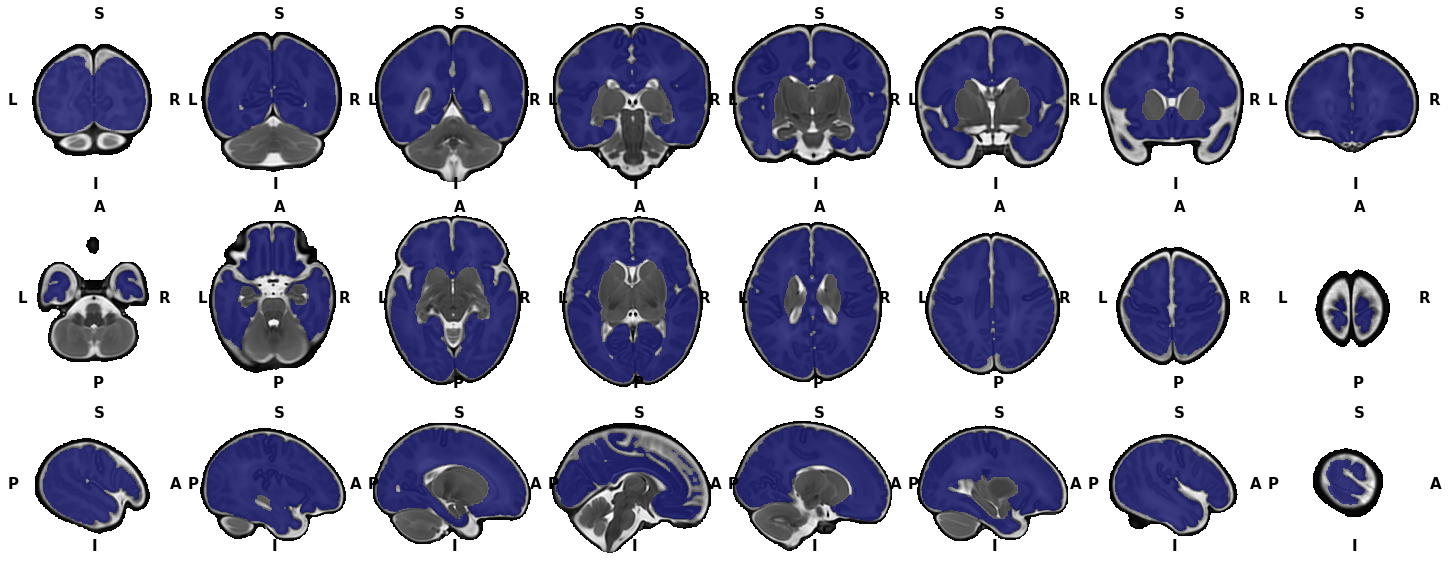

In [49]:
fig,axes = plt.subplots(3,8,figsize=(20,8),layout='constrained')
# axes = axes.flatten()
jacobians_effect_sizes=visualisation.Brainmap(atlas_file='../../codes/DrawEMVol/mask_gm_wm_only.nii.gz')
jacobians_effect_sizes.atlas[jacobians_effect_sizes.atlas==0]=np.nan
vmin = np.min(jacobians_effect_sizes.atlas[~np.isnan(jacobians_effect_sizes.atlas)])
vmax = np.max(jacobians_effect_sizes.atlas[~np.isnan(jacobians_effect_sizes.atlas)])

for ax,atlas_slice in zip(axes[0,:],np.linspace(40,180,8)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['coronal'],
        atlas_file='../../codes/DrawEMVol/week40_T2w.nii.gz',T2=True,cmap='gray',axes=[ax])
    ax.imshow(np.rot90(jacobians_effect_sizes.atlas[:,int(atlas_slice),:]),alpha=.55,cmap='jet',
              vmin=vmin,vmax=vmax)
for ax,atlas_slice in zip(axes[1,:],np.linspace(40,180,8)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['axial'],
        atlas_file='../../codes/DrawEMVol/week40_T2w.nii.gz',T2=True,cmap='gray',axes=[ax])
    ax.imshow(np.rot90(jacobians_effect_sizes.atlas[:,:,int(atlas_slice)]),alpha=.55,cmap='jet',
              vmin=vmin,vmax=vmax)
for ax,atlas_slice in zip(axes[2,:],np.linspace(30,180,8)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['sagittal'],
        atlas_file='../../codes/DrawEMVol/week40_T2w.nii.gz',T2=True,cmap='gray',axes=[ax])
    last_image = ax.imshow(np.rot90(jacobians_effect_sizes.atlas[int(atlas_slice),:,:]),
              alpha=.55,cmap='jet',
              vmin=vmin,vmax=vmax)

# cbar = fig.colorbar(last_image,ax=axes[:,-1],orientation='vertical',shrink=.6)
# cbar.solids.set(alpha=1)
# cbar.ax.tick_params(labelsize=15)
# cbar.set_label(r'$\beta$',rotation=270,fontsize=20)

fig.savefig('jacobians_mask.png')

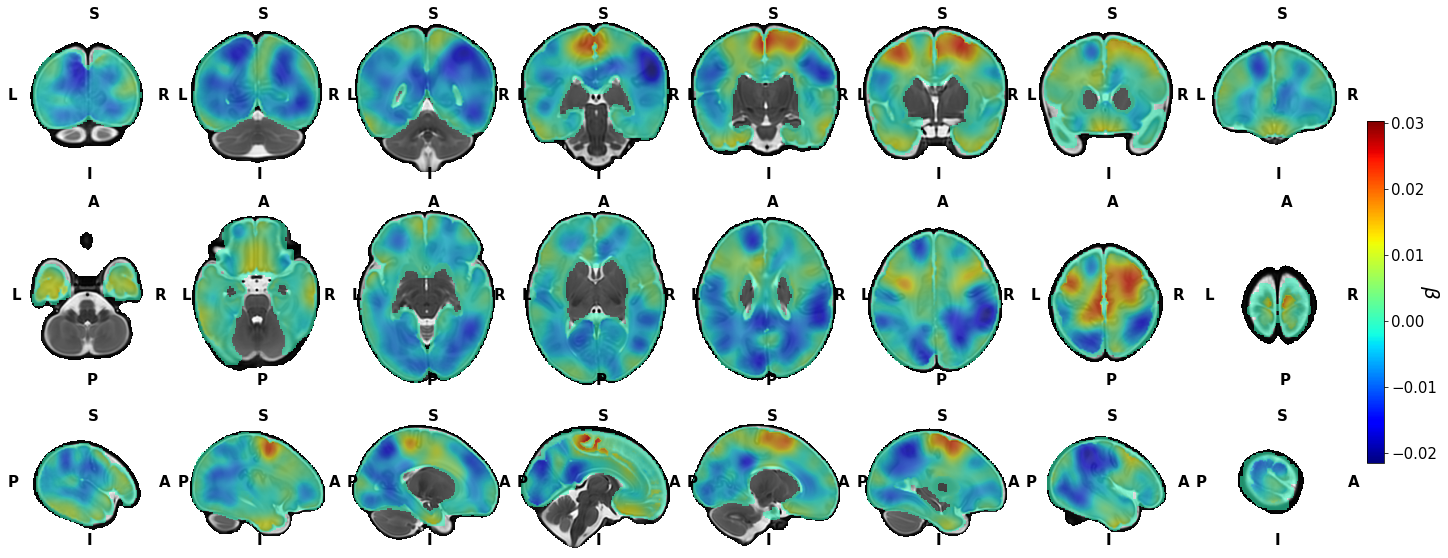

In [19]:
fig,axes = plt.subplots(3,8,figsize=(20,8),layout='constrained')
# axes = axes.flatten()
jacobians_effect_sizes=visualisation.Brainmap(atlas_file='../../codes/DrawEMVol/output_Jacobians/cortical_only_4sigma_1mm/ASD_PC1/regrided_statbeta4.nii.gz')
jacobians_effect_sizes.atlas[jacobians_effect_sizes.atlas==0]=np.nan
vmin = np.min(jacobians_effect_sizes.atlas[~np.isnan(jacobians_effect_sizes.atlas)])
vmax = np.max(jacobians_effect_sizes.atlas[~np.isnan(jacobians_effect_sizes.atlas)])

for ax,atlas_slice in zip(axes[0,:],np.linspace(40,180,8)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['coronal'],
        atlas_file='../../codes/DrawEMVol/week40_T2w.nii.gz',T2=True,cmap='gray',axes=[ax])
    ax.imshow(np.rot90(jacobians_effect_sizes.atlas[:,int(atlas_slice),:]),alpha=.55,cmap='jet',
              vmin=vmin,vmax=vmax)
for ax,atlas_slice in zip(axes[1,:],np.linspace(40,180,8)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['axial'],
        atlas_file='../../codes/DrawEMVol/week40_T2w.nii.gz',T2=True,cmap='gray',axes=[ax])
    ax.imshow(np.rot90(jacobians_effect_sizes.atlas[:,:,int(atlas_slice)]),alpha=.55,cmap='jet',
              vmin=vmin,vmax=vmax)
for ax,atlas_slice in zip(axes[2,:],np.linspace(30,180,8)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['sagittal'],
        atlas_file='../../codes/DrawEMVol/week40_T2w.nii.gz',T2=True,cmap='gray',axes=[ax])
    last_image = ax.imshow(np.rot90(jacobians_effect_sizes.atlas[int(atlas_slice),:,:]),
              alpha=.55,cmap='jet',
              vmin=vmin,vmax=vmax)

cbar = fig.colorbar(last_image,ax=axes[:,-1],orientation='vertical',shrink=.6)
cbar.solids.set(alpha=1)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\beta$',rotation=270,fontsize=20)

fig.savefig('jacobians_beta_values.png',dpi=300)

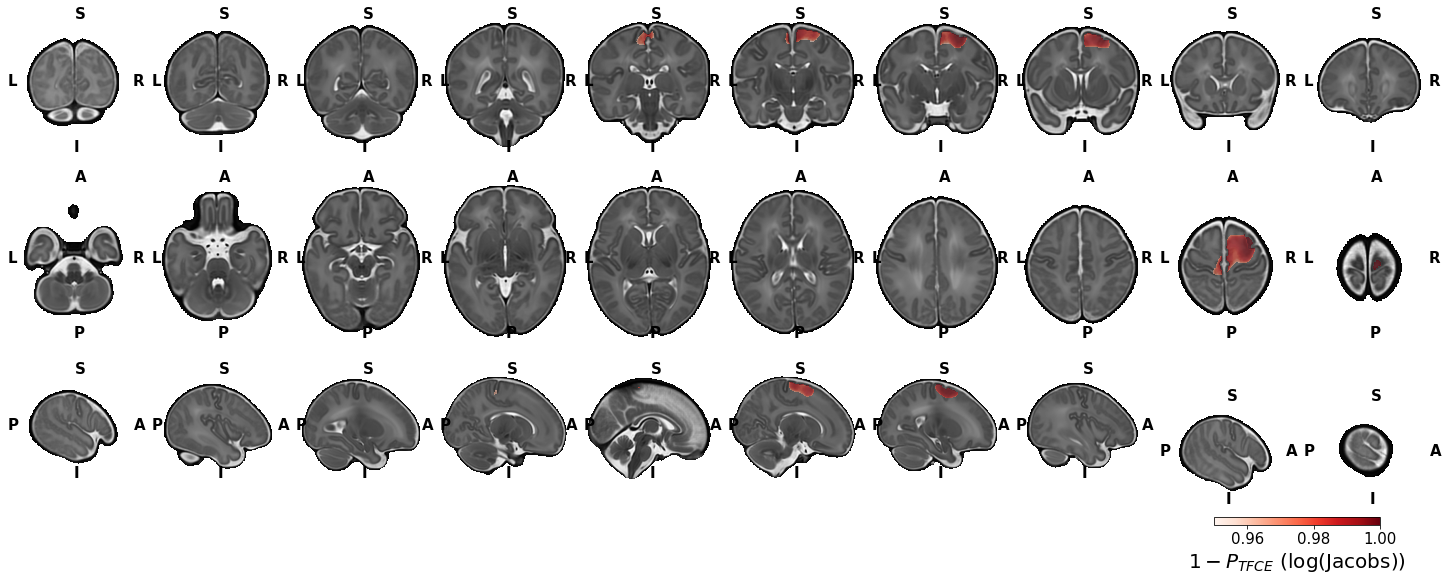

In [56]:
number_plot=10
fig,axes = plt.subplots(3,number_plot,figsize=(20,8),layout='constrained')
# axes = axes.flatten()
jacobians_p_value_pos=visualisation.Brainmap(atlas_file='../../codes/DrawEMVol/output_Jacobians/cortical_only_5sigma_1mm/ASD_PC1/regrided_statfwe_1mpvalue_t2.nii.gz')

jacobians_p_value_neg=visualisation.Brainmap(atlas_file='../../codes/DrawEMVol/output_Jacobians/cortical_only_5sigma_1mm/ASD_PC1/regrided_statfwe_1mpvalue_t1.nii.gz')

vmin = 0.95
vmax = 1
jacobians_p_value_pos.atlas[jacobians_p_value_pos.atlas<=vmin]=np.nan
jacobians_p_value_neg.atlas[jacobians_p_value_neg.atlas<=vmin]=np.nan

cmap_pos='Reds'
cmap_neg='Blues'

for ax,atlas_slice in zip(axes[0,:],np.linspace(40,180,number_plot)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['coronal'],
        atlas_file='../../codes/DrawEMVol/week40_T2w.nii.gz',T2=True,cmap='gray',axes=[ax])
    ax.imshow(np.rot90(jacobians_p_value_pos.atlas[:,int(atlas_slice),:]),
              alpha=.55,cmap=cmap_pos,
              vmin=vmin,vmax=vmax)
    ax.imshow(np.rot90(jacobians_p_value_neg.atlas[:,int(atlas_slice),:]),
              alpha=.55,cmap=cmap_neg,
              vmin=vmin,vmax=vmax)
for ax,atlas_slice in zip(axes[1,:],np.linspace(40,180,number_plot)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['axial'],
        atlas_file='../../codes/DrawEMVol/week40_T2w.nii.gz',T2=True,cmap='gray',axes=[ax])
    ax.imshow(np.rot90(jacobians_p_value_pos.atlas[:,:,int(atlas_slice)]),
              alpha=.55,cmap=cmap_pos,
              vmin=vmin,vmax=vmax)
    ax.imshow(np.rot90(jacobians_p_value_neg.atlas[:,:,int(atlas_slice)]),
              alpha=.55,cmap=cmap_neg,
              vmin=vmin,vmax=vmax)
for ax,atlas_slice in zip(axes[2,:],np.linspace(30,180,number_plot)):
    _,_ = visualisation.Brainmap.plot_segmentation(
        atlas_slice=int(atlas_slice),
        map_view=['sagittal'],
        atlas_file='../../codes/DrawEMVol/week40_T2w.nii.gz',T2=True,cmap='gray',axes=[ax])
    last_image_pos = ax.imshow(np.rot90(jacobians_p_value_pos.atlas[int(atlas_slice),:,:]),
              alpha=.55,cmap=cmap_pos,
              vmin=vmin,vmax=vmax)
    last_image_neg = ax.imshow(np.rot90(jacobians_p_value_neg.atlas[int(atlas_slice),:,:]),
              alpha=.55,cmap=cmap_neg,
              vmin=vmin,vmax=vmax)

cbar_pos = fig.colorbar(last_image_pos,ax=axes[-1,-2:],orientation='horizontal',shrink=.6)
# cbar_neg = fig.colorbar(last_image_neg,ax=axes[-1,0:2],orientation='horizontal',shrink=.6)

cbar_pos.solids.set(alpha=1)
# cbar_neg.solids.set(alpha=1)
cbar_pos.ax.tick_params(labelsize=15)
# cbar_neg.ax.tick_params(labelsize=15)

cbar_pos.set_label(r'$1-P_{TFCE}$ (log(Jacobs))',fontsize=20)
# cbar_neg.set_label(r'$1-P_{TFCE}$ (-log(Jacobs))',fontsize=20)
fig.savefig('jacobians_p_values_most_significant.png')
# plt.tight_layout()